In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler,LabelEncoder 
from sklearn.metrics import accuracy_score,classification_report
from imblearn.over_sampling import SMOTE 
import pickle

Import Data

In [2]:
df = pd.read_csv('heart.csv')
df.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
912,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
368,57,M,ASY,140,0,0,Normal,120,Y,2.0,Flat,1
906,55,F,ATA,132,342,0,Normal,166,N,1.2,Up,0
539,57,M,ASY,110,197,0,LVH,100,N,0.0,Up,0
693,42,F,NAP,120,209,0,Normal,173,N,0.0,Flat,0


## 1. Data Understanding

In [3]:
print('Data Shape :',df.shape)

Data Shape : (918, 12)


In [4]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [7]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

## 2. Cleaning Data

In [8]:
print('Data Shape :',df.shape)

Data Shape : (918, 12)


In [9]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
print('Data Shape :',df.shape)

Data Shape : (918, 12)


## 3. Exploratory Data Analysis (EDA)

In [13]:
df['Sex'] = df['Sex'].map({'M':'Male', 'F':'Female'})
df['ChestPainType'] = df['ChestPainType'].map({'TA':'Typical Angina', 'ATA':'Atypical Angina', 
                                               'NAP' : 'Non-Anginal Pain', 'ASY' : 'Asymptomatic'})
df['FastingBS'] = df['FastingBS'].map({1: 'FastingBS > 120 mg/dl', 0: 'Else'})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 'Yes', 'N': 'No'})
df['HeartDisease'] = df['HeartDisease'].map({1: 'Heart Disease', 0: 'Normal'})

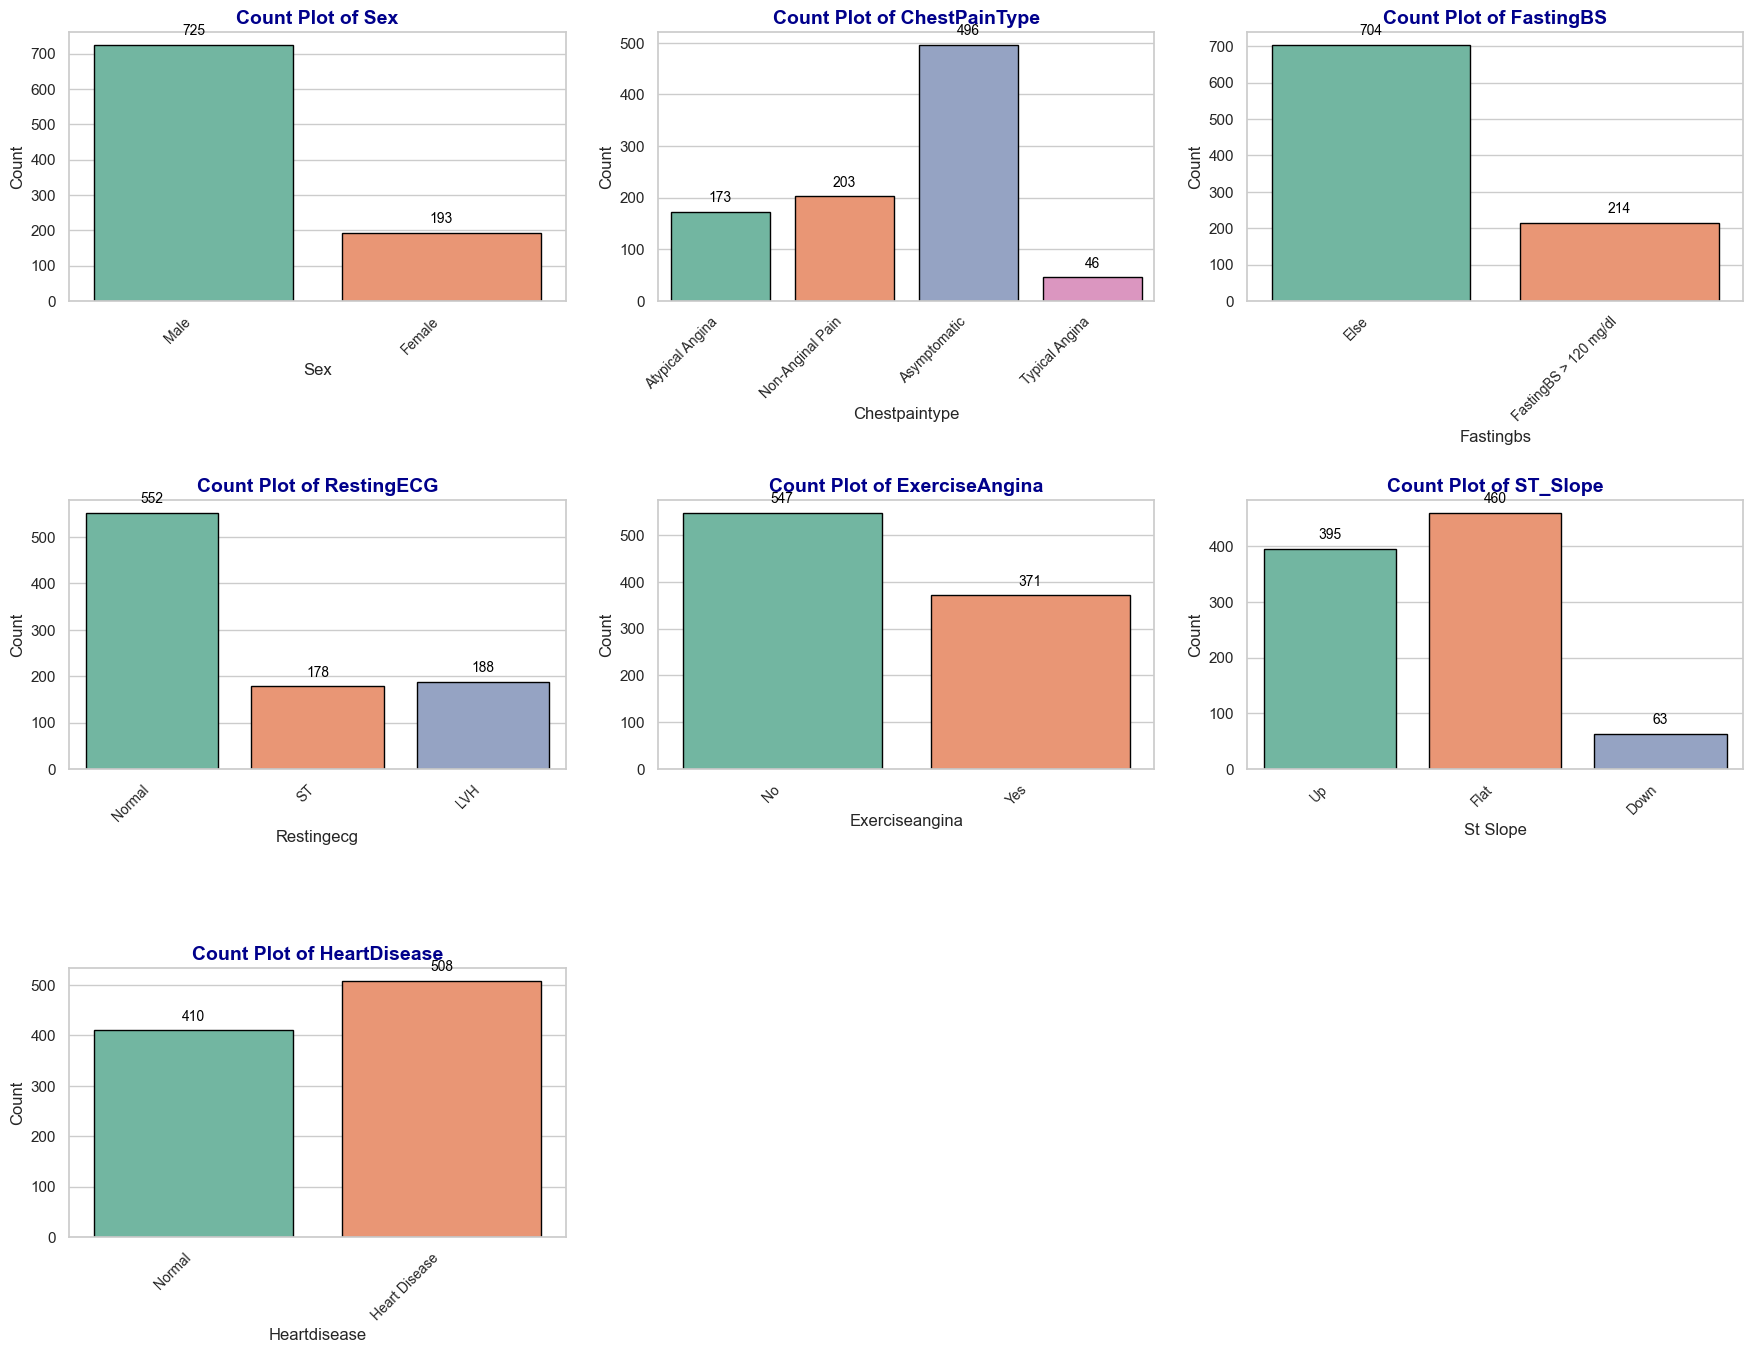

In [14]:
Column_Categories = ['Sex', 'ChestPainType', 'FastingBS',
                     'RestingECG', 'ExerciseAngina', 'ST_Slope',
                     'HeartDisease']
# Set the figure size and background style
plt.figure(figsize=(18, 14))
sns.set(style="whitegrid")

# Loop through each column and create count plots with customization
for i, col in enumerate(Column_Categories, 1):
    plt.subplot(3, 3, i)  # Create a 2x3 grid layout
    ax = sns.countplot(data=df, x=col, palette="Set2", edgecolor="black")
    plt.title(f'Count Plot of {col}', fontsize=14, fontweight='bold', color='darkblue')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel("Count", fontsize=12)

    # Adding count labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points', fontsize=10, color='black')

# Adjust layout to avoid overlap and display
plt.tight_layout(pad=2)
plt.show()

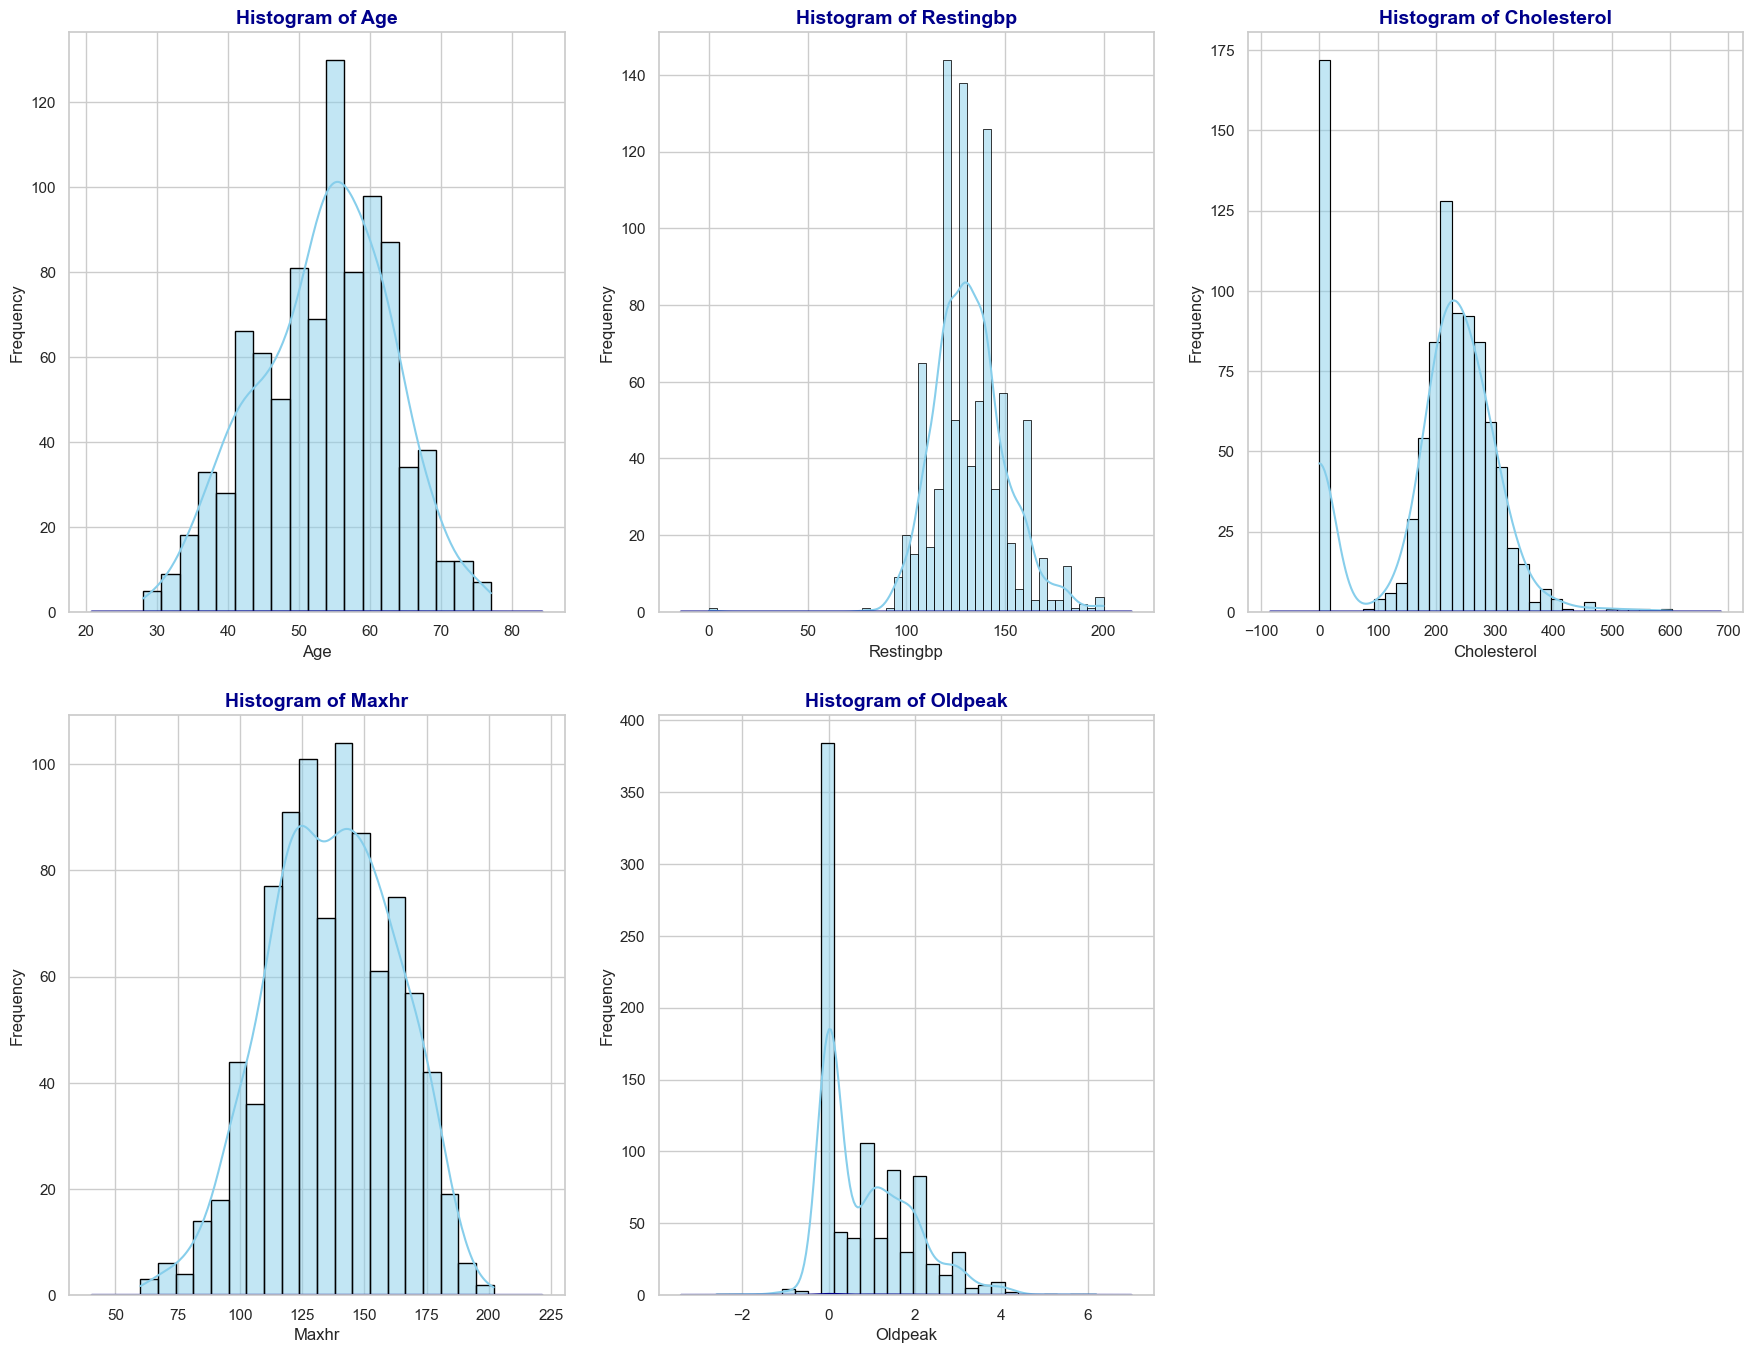

In [15]:
Column_Numerics = ['Age', 'RestingBP', 'Cholesterol','MaxHR', 'Oldpeak']
# Set figure size and background style
plt.figure(figsize=(18, 14))
sns.set(style="whitegrid")

# Loop through each column and create histograms with customization
for i, col in enumerate(Column_Numerics, 1):
    plt.subplot(2, 3, i)  # Create a 3x3 grid layout
    ax = sns.histplot(data=df, x=col, kde=True, color="skyblue", edgecolor="black")
    sns.kdeplot(data=df[col], ax=ax, color="darkblue", linewidth=2)  # Custom KDE line color and thickness
    
    # Title and labels customization
    plt.title(f'Histogram of {col.replace("_", " ").title()}', fontsize=14, fontweight='bold', color='darkblue')
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

# Adjust layout and display
plt.tight_layout(pad=2)
plt.show()

## 4. Preperation Data

In [16]:
le = LabelEncoder()
HeartDisease = {'Heart Disease': 1, 'Normal': 0}
df['HeartDisease'] = df['HeartDisease'].map(HeartDisease)
for column in Column_Categories:
    df[column] = le.fit_transform(df[column])
    for i, atribut in enumerate(le.classes_):
        print(f'The attribute of {column} -> "{atribut}" is converted to: {i}')

The attribute of Sex -> "Female" is converted to: 0
The attribute of Sex -> "Male" is converted to: 1
The attribute of ChestPainType -> "Asymptomatic" is converted to: 0
The attribute of ChestPainType -> "Atypical Angina" is converted to: 1
The attribute of ChestPainType -> "Non-Anginal Pain" is converted to: 2
The attribute of ChestPainType -> "Typical Angina" is converted to: 3
The attribute of FastingBS -> "Else" is converted to: 0
The attribute of FastingBS -> "FastingBS > 120 mg/dl" is converted to: 1
The attribute of RestingECG -> "LVH" is converted to: 0
The attribute of RestingECG -> "Normal" is converted to: 1
The attribute of RestingECG -> "ST" is converted to: 2
The attribute of ExerciseAngina -> "No" is converted to: 0
The attribute of ExerciseAngina -> "Yes" is converted to: 1
The attribute of ST_Slope -> "Down" is converted to: 0
The attribute of ST_Slope -> "Flat" is converted to: 1
The attribute of ST_Slope -> "Up" is converted to: 2
The attribute of HeartDisease -> "0"

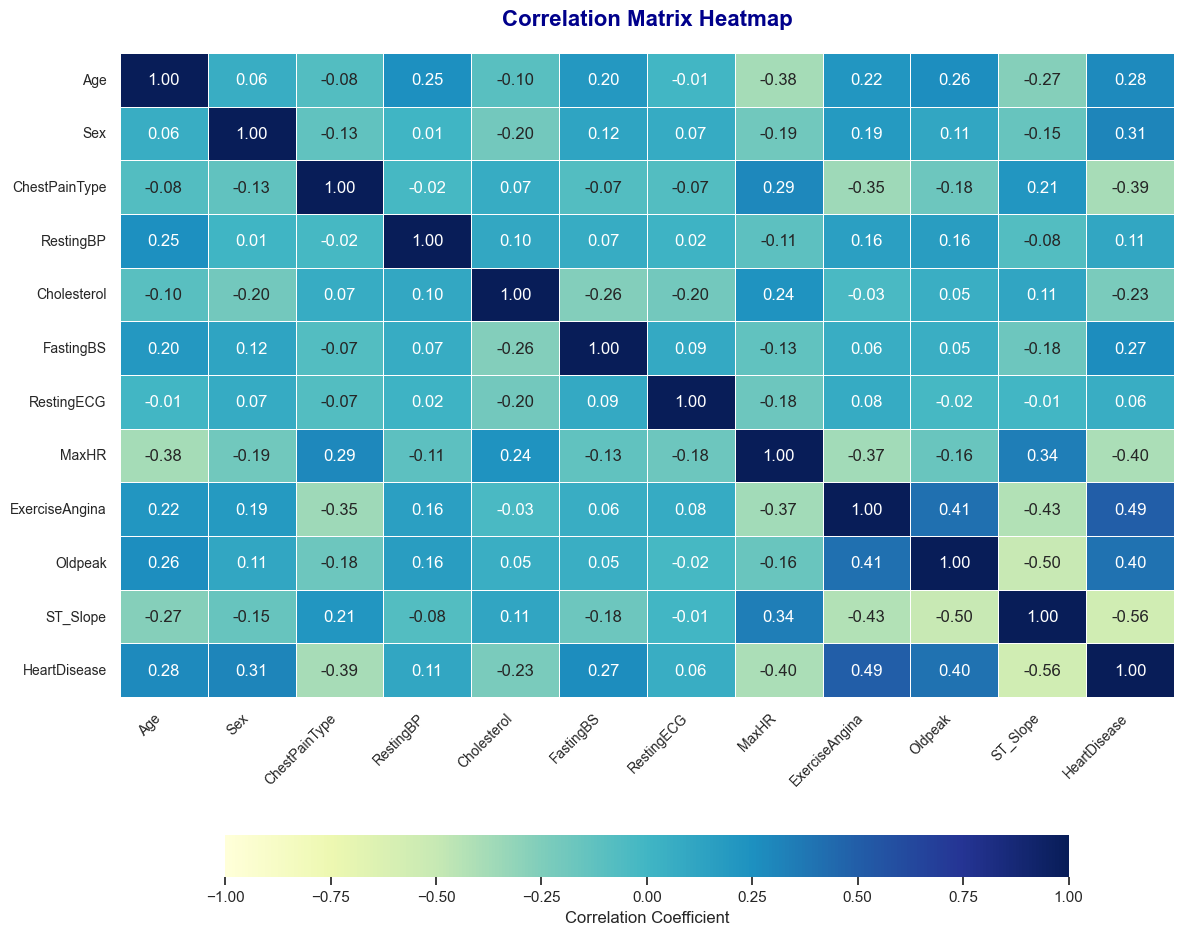

In [17]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Set figure size and background style
plt.figure(figsize=(12, 10))
sns.set(style="white")  # Clean background style

# Create heatmap with customization
sns.heatmap(corr_matrix, 
            cmap='YlGnBu',          # Updated color palette
            annot=True,             # Display correlation values
            fmt=".2f",              # Format annotations to 2 decimal places
            linewidths=0.7,         # Add spacing between cells
            vmin=-1, vmax=1,        # Set range of color bar
            cbar_kws={"shrink": 0.8, "orientation": "horizontal", "label": "Correlation Coefficient"})

# Title customization
plt.title("Correlation Matrix Heatmap", fontsize=16, fontweight='bold', color='darkblue', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate and format x-axis labels
plt.yticks(fontsize=10)

# Display plot
plt.tight_layout()
plt.show()


In [18]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
print(f'X Shape: {X.shape}')
print(f'y Shape: {y.shape}')

X Shape: (918, 11)
y Shape: (918,)


## 5. Modelling & Evaluation Data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (734, 11)
X_test Shape: (184, 11)
y_train Shape: (734,)
y_test Shape: (184,)


In [20]:
scaler = StandardScaler()
sc_xtrain = scaler.fit_transform(X_train)
sc_xtest = scaler.transform(X_test)
# pickle.dump(scaler, open('Streamlit/scaler.pkl', 'wb'))
# print('File tersimpan')

In [21]:
# oversampling
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(sc_xtrain, y_train)

In [22]:
models = {
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'SVM': (SVC(random_state=42), {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    })
}

In [23]:
acc = []
f1_scores = []
precision_scores = []
recall_scores = []

In [24]:
# Perform Grid Search for each model
for model_name, (model, param_grid) in models.items():
    print(f"\nPerforming Grid Search for {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
    grid_search.fit(X_train_sm, y_train_sm)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(sc_xtest)
    accuracy = accuracy_score(y_test, y_pred) * 100
    accuracy = f"{accuracy:.1f}%"
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    acc.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    pickle.dump(best_model, open(f'Streamlit/{model_name}.pkl', 'wb'))
    print(f'Training & save model {model_name} Done.')


Performing Grid Search for RandomForestClassifier...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training & save model RandomForestClassifier Done.

Performing Grid Search for SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Training & save model SVM Done.

Performing Grid Search for KNN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Training & save model KNN Done.


### Save The Evaluation Models

In [25]:
models = [
    'RandomForestClassifier',
    'KNeighborsClassifier',
    'SVM'
]
result_model = {
    'Model': models,
    'Accuracy':acc,
    'F1_Score': f1_scores,
    'Recall': recall_scores,
    'Precisions': precision_scores,
}
df_model = pd.DataFrame(result_model)

In [26]:
df_model.sort_values(by='Accuracy',ascending=False,ignore_index=True)

,Model,Accuracy,F1_Score,Recall,Precisions
0,RandomForestClassifier,88.0%,0.880810,0.880435,0.882024
1,KNeighborsClassifier,87.5%,0.875604,0.875000,0.878750
2,SVM,81.5%,0.816447,0.815217,0.829993


the best model for this dataset is **RandomForestClassifier**